In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# IMDB数据集
我们将使用“IMDB数据集”，这是一组来自互联网电影数据库的50,000个高度两极化的评论。他们分为25,000次的培训评论和25,000次的测试评审，每组包括50%的负面评论和50%的正面评价。

为什么我们有这两个单独的训练和测试集？你永远不应该在你用来训练机器学习的数据上测试机器学习模型！仅仅因为一个模型在其训练数据上表现良好并不意味着它将在它从未见过的数据上表现良好，而您真正关心的是您的模型在新数据上的性能(因为您已经知道您的培训数据的标签--显然您不需要您的模型来预测这些数据)。

就像MNIST数据集一样，IMDB数据集与Keras一起打包。它已经被预处理了：评论(单词序列)已经转化为整数序列，其中每个整数代表字典中的特定单词。


In [2]:
# 3-1加载数据
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10000)

# 
参数num_words=10000这意味着我们只会在训练数据中保留前10,000个最常见的单词。罕见的词语将被丢弃。这使我们能够处理可管理大小的矢量数据。

变量train_data和test_data是评论列表，每个评论都是一个单词索引列表(编码一个单词序列)。train_labels和test_labels都是0和1组成的列表，其中0表示“否定”，1表示“正面”。

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

1

# 
由于我们限制在前10,000个最频繁的单词上，所以没有一个单词索引会超过10,000：

In [5]:
max([max(sequence) for sequence in train_data])

9999

# 
下面是如何快速地将其中一个评论解码回英语单词的方法

In [6]:
word_index = tf.keras.datasets.imdb.get_word_index()

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

# 准备数据
我们不能将整数列表输入到神经网络中。我们必须把我们的列表变成张量。我们有两种方法可以做到这一点：

1 我们可以在列表中填充，使它们都具有相同的长度，并将它们转化为形状为(samples, word_indices)整数向量，然后在我们的网络中使用一个能够处理这种整数张量的层(Embedding层，我们将在后面详细介绍)。

2 我们可以对我们的列表进行一次热编码，将其转化为0和1的向量。具体来说，这意味着，例如，转动序列[3, 5]变成一个10,000维向量，索引3和5的元素是1。然后我们可以在我们的网络中使用一个Dense层，它能够处理浮点矢量数据。

我们将采用后一种解决办法。让我们将数据矢量化，为了达到最大的清晰度，我们将手动完成这些工作：

In [9]:
# 3-2将整数序列编码为二进制矩阵
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # 创建一个形状为(len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # 将results[i]的指定索引设为1
    return results

# 向量化
x_train = vectorize_sequences(train_data)

x_test = vectorize_sequences(test_data)

In [10]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [11]:
# 便签向量化
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# 
现在我们的数据已经准备好输入神经网络了。

# 建立我们的网络
我们的输入数据只是向量，我们的标签是标量(1和0)：这是您所遇到的最简单的设置。在这种问题上表现良好的一种网络类型是一个简单的完全连接的(Dense)层relu激活：Dense(16, activation='relu')

传递给每个人的参数Dense层(16)是该层的“隐藏单元”的数目。什么是隐藏的单位？这是层的表示空间中的一个维度。

output = relu(dot(W, input) + b)

16个隐藏单位对应的权重矩阵W的形状为(input_dimension, 16)，与W做点积相当于将输入数据投影到16维表示空间中（然后我们再加上偏置向量b，并应用relu运算）。可以将表示空间的维度直观的理解为“网络学习内部表示时拥有的自由度”。隐藏单元越多，网络越能够学习更加复杂的表示，但是也可能导致学习到不好的模式。

对于这种Dense的堆叠，需要确定一下两个关键架构：

网络有多少层，
每层有多少个隐藏单元

我们使用以下架构：两个中间层，每个层有16个隐藏单元，第三层将输出关于当前评审情绪的标量预测。中间层将使用relu作为它们的“激活函数”，最后一层将使用Sigmoid激活函数，以便输出概率介于0到1之间，表明样本有多大可能具有目标“1”，即审查是否可能为正。

In [13]:
# 3-3定义模型
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# 
最后，我们需要选择一个损失函数和一个优化器。由于我们正面临一个二分类问题，网络的输出是一个概率，所以最好使用binary_crossentropy（二元交叉熵）损失。这不是唯一可行的选择：例如，mean_squared_error（均方误差）。但是当你处理输出概率的模型时，交叉熵通常是最好的选择。交叉熵是信息论领域的一个概念，它测量概率分布之间的“距离”，在这个例子中就是真实分布与预测值之间的距离。

下面是使用rmsprop优化器和binary_crossentropy损失函数来配置模型。

In [14]:
# 3-4编译模型
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 
我们将优化器、损失函数和指标作为字符串传入，这是因为rmsprop, binary_crossentropy和accuracy都是Keras内置的一部分。

In [15]:
# 3-5配置优化器
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
# 3-6使用自定义的损失和指标
from tensorflow.keras import losses
from tensorflow.keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

# 验证我们的方法
为了在训练过程中监测模型对以前从未见过的数据的准确性，我们将从原始训练数据中分离10 000个样本，创建一个“验证集”：

In [17]:
# 3-7留出验证集
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# 
我们现在将对所有样本进行20次迭代。批量为512个样本。同时，我们将监测我们所分离的10,000个样本的损失和精度。你可以通过将验证数据传入validation_data参数完成

In [22]:
# 3-8训练模型

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 5s 342us/sample - loss: 0.5342 - binary_accuracy: 0.7837 - val_loss: 0.4111 - val_binary_accuracy: 0.8637
Epoch 2/20
15000/15000 [==============================] - 2s 110us/sample - loss: 0.3309 - binary_accuracy: 0.8971 - val_loss: 0.3173 - val_binary_accuracy: 0.8844
Epoch 3/20
15000/15000 [==============================] - 2s 100us/sample - loss: 0.2409 - binary_accuracy: 0.9205 - val_loss: 0.2898 - val_binary_accuracy: 0.8857
Epoch 4/20
15000/15000 [==============================] - 1s 96us/sample - loss: 0.1886 - binary_accuracy: 0.9366 - val_loss: 0.2894 - val_binary_accuracy: 0.8831
Epoch 5/20
15000/15000 [==============================] - 1s 94us/sample - loss: 0.1522 - binary_accuracy: 0.9501 - val_loss: 0.2766 - val_binary_accuracy: 0.8875
Epoch 6/20
15000/15000 [==============================] - 2s 111us/sample - loss: 0.1288 - binary_accuracy: 0.9588 - val_loss: 0.296

# 
调用model.fit()返回History对象。这个对象有一个成员history，它是一个字典，包含关于训练过程中的所有数据。

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

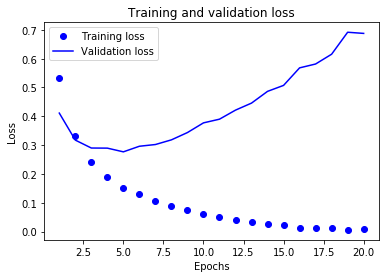

In [25]:
# 3-9绘制训练损失和验证损失
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

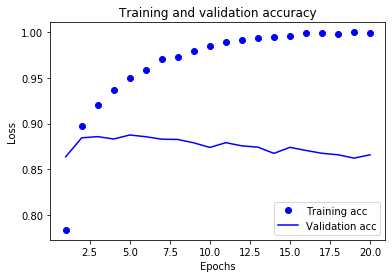

In [26]:
# 3-10绘制训练精度和验证精度
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 
点是训练的损失和精度，实线是验证的损失和精度。


In [27]:
# 3-11从头开始重新训练一个模型
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 2s 88us/sample - loss: 0.5089 - accuracy: 0.8015
Epoch 2/4
25000/25000 [==============================] - 1s 51us/sample - loss: 0.2976 - accuracy: 0.9060
Epoch 3/4
25000/25000 [==============================] - 1s 53us/sample - loss: 0.2210 - accuracy: 0.9233
Epoch 4/4
25000/25000 [==============================] - 1s 51us/sample - loss: 0.1803 - accuracy: 0.9390
25000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [28]:
results

[0.30413572069168093, 0.87932]

# 使用训练好的网络在新数据上生成预测结果
在训练了一个网络之后，你会想要在一个实际的环境中使用它。您可以使用predict方法：

In [29]:
model.predict(x_test)

array([[0.17270085],
       [0.99989384],
       [0.79147196],
       ...,
       [0.1008195 ],
       [0.06435096],
       [0.53702533]], dtype=float32)

# 结论 

通常需要对原始数据进行大量预处理，单词序列可以编码为二进制向量，但也有其他编码方式。

对于二分类问题，网络的最后一层应该只有一个单元并使用sigmoid激活函数，输出应该时0-1范围的标量，表示概率值。

对于二分类问题的sigmoid标量输出，应该用binary_crossentropy损失函数。